In [1]:
# Import necessary libraries
import os
import numpy as np
import scipy.io
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             classification_report, confusion_matrix)
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import NotFittedError
import matplotlib.pyplot as plt
import seaborn as sns
import ot  # Optimal Transport library
import warnings
warnings.filterwarnings('ignore')


In [2]:
from sklearn.ensemble import IsolationForest

class DataPreprocessor:
    """
    Handles data loading, outlier detection, class imbalance handling, and data normalization.
    """

    def __init__(self, domain, data_dir='../data/CaffeNet'):
        """
        Initializes the DataPreprocessor with the given domain.

        Parameters:
        - domain: str, name of the domain (e.g., 'webcam', 'dslr')
        - data_dir: str, directory where the data is stored
        """
        self.domain = domain
        self.data_dir = data_dir
        self.X = None
        self.y = None
        self.scaler = StandardScaler()

    def load_data(self):
        """
        Loads data from the .mat file for the specified domain.
        """
        file_path = os.path.join(self.data_dir, f'{self.domain}.mat')
        try:
            data = scipy.io.loadmat(file_path)
            self.X = data['fts']
            self.y = data['labels'].ravel()
            print(f"Loaded data from {file_path}. Shape: {self.X.shape}, Labels: {len(self.y)}")
        except FileNotFoundError:
            print(f"File {file_path} not found.")
            raise
        except KeyError as e:
            print(f"Key {e} not found in the .mat file.")
            raise

    def visualize_class_distribution(self, title='Class Distribution'):
        """
        Visualizes the class distribution in the dataset.
        """
        unique, counts = np.unique(self.y, return_counts=True)
        plt.figure(figsize=(8, 4))
        sns.barplot(x=unique, y=counts, palette='viridis')
        plt.title(f'{title} ({self.domain})')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.show()

    def remove_outliers(self, contamination=0.05):
        """
        Identifies and removes outliers using Isolation Forest.

        Parameters:
        - contamination: float, the proportion of outliers in the data set.
        """
        iso_forest = IsolationForest(contamination=contamination, random_state=42)
        y_pred = iso_forest.fit_predict(self.X)
        mask = y_pred != -1  # -1 indicates outliers
        removed = np.sum(~mask)
        self.X = self.X[mask]
        self.y = self.y[mask]
        print(f"Outliers removed: {removed}")

    def handle_class_imbalance(self):
        """
        Handles class imbalance by upsampling minority classes.
        """
        unique_classes, counts = np.unique(self.y, return_counts=True)
        max_count = np.max(counts)
        X_resampled = []
        y_resampled = []
        for cls in unique_classes:
            X_cls = self.X[self.y == cls]
            y_cls = self.y[self.y == cls]
            if len(X_cls) < max_count:
                X_upsampled, y_upsampled = resample(
                    X_cls, y_cls,
                    replace=True,
                    n_samples=max_count - len(X_cls),
                    random_state=42
                )
                X_resampled.append(np.vstack((X_cls, X_upsampled)))
                y_resampled.append(np.hstack((y_cls, y_upsampled)))
            else:
                X_resampled.append(X_cls)
                y_resampled.append(y_cls)
        self.X = np.vstack(X_resampled)
        self.y = np.hstack(y_resampled)
        print("Class imbalance handled via upsampling.")

    def normalize_data(self):
        """
        Normalizes the data using z-score normalization.
        """
        self.X = self.scaler.fit_transform(self.X)
        print("Data normalized using z-score normalization.")

    def preprocess(self, remove_outliers=False, balance_classes=False):
        """
        Runs the full preprocessing pipeline.

        Parameters:
        - remove_outliers: bool, whether to remove outliers.
        - balance_classes: bool, whether to handle class imbalance.
        """
        self.load_data()
        self.normalize_data()
        if remove_outliers:
            self.remove_outliers()
            self.normalize_data()  # Re-normalize after outlier removal
        if balance_classes:
            self.handle_class_imbalance()
            self.normalize_data()  # Re-normalize after balancing


In [3]:
class CustomKernelPCA:
    """
    Implements Kernel PCA for non-linear dimensionality reduction.
    """

    def __init__(self, n_components=2, kernel='rbf', gamma=None, degree=3, coef0=1):
        """
        Initializes the CustomKernelPCA.

        Parameters:
        - n_components: int, number of components.
        - kernel: str, type of kernel ('linear', 'poly', 'rbf', 'sigmoid', 'cosine').
        - gamma: float, kernel coefficient for 'rbf', 'poly', and 'sigmoid'.
        - degree: int, degree for 'poly' kernel.
        - coef0: float, independent term in 'poly' and 'sigmoid' kernels.
        """
        self.n_components = n_components
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.alphas = None
        self.lambdas = None
        self.X_fit_ = None

    def _kernel_function(self, X, Y):
        """
        Computes the kernel function between X and Y.

        Parameters:
        - X: array-like, shape (n_samples_X, n_features)
        - Y: array-like, shape (n_samples_Y, n_features)

        Returns:
        - K: Kernel matrix
        """
        if self.kernel == 'linear':
            K = X @ Y.T
        elif self.kernel == 'poly':
            K = (self.gamma * X @ Y.T + self.coef0) ** self.degree
        elif self.kernel == 'rbf':
            if self.gamma is None:
                self.gamma = 1 / X.shape[1]
            sq_dists = cdist(X, Y, 'sqeuclidean')
            K = np.exp(-self.gamma * sq_dists)
        elif self.kernel == 'sigmoid':
            K = np.tanh(self.gamma * X @ Y.T + self.coef0)
        elif self.kernel == 'cosine':
            X_norm = X / np.linalg.norm(X, axis=1, keepdims=True)
            Y_norm = Y / np.linalg.norm(Y, axis=1, keepdims=True)
            K = X_norm @ Y_norm.T
        else:
            raise ValueError(f"Unsupported kernel: {self.kernel}")
        return K

    def _center_kernel(self, K):
        """
        Centers the kernel matrix K.

        Parameters:
        - K: Kernel matrix

        Returns:
        - K_centered: Centered Kernel matrix
        """
        N = K.shape[0]
        one_n = np.ones((N, N)) / N
        K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n
        return K_centered

    def fit(self, X):
        """
        Fits the model with X.

        Parameters:
        - X: array-like, shape (n_samples, n_features)
        """
        self.X_fit_ = X
        K = self._kernel_function(X, X)
        K_centered = self._center_kernel(K)
        # Eigenvalue decomposition
        eigvals, eigvecs = np.linalg.eigh(K_centered)
        # Sort eigenvalues and eigenvectors in descending order
        idx = np.argsort(eigvals)[::-1]
        eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]
        # Store the top n_components
        self.lambdas = eigvals[:self.n_components]
        self.alphas = eigvecs[:, :self.n_components]
        # Normalize eigenvectors
        self.alphas = self.alphas / np.sqrt(self.lambdas)
        return self

    def transform(self, X):
        """
        Transforms X.

        Parameters:
        - X: array-like, shape (n_samples, n_features)

        Returns:
        - X_transformed: array-like, shape (n_samples, n_components)
        """
        K = self._kernel_function(X, self.X_fit_)
        K_centered = self._center_kernel(K)
        return K_centered @ self.alphas

    def fit_transform(self, X):
        """
        Fits the model with X and transforms X.

        Parameters:
        - X: array-like, shape (n_samples, n_features)

        Returns:
        - X_transformed: array-like, shape (n_samples, n_components)
        """
        self.fit(X)
        return self.transform(X)


In [4]:
class SubspaceAlignmentDA:
    """
    Implements Subspace Alignment Domain Adaptation using Kernel PCA.
    """

    def __init__(self, n_components=20, kernel='linear', **kernel_params):
        """
        Initializes the SubspaceAlignmentDA.

        Parameters:
        - n_components: int, number of components for Kernel PCA.
        - kernel: str, type of kernel for Kernel PCA.
        - kernel_params: additional kernel parameters.
        """
        self.n_components = n_components
        self.kernel = kernel
        self.kernel_params = kernel_params
        self.Xs_proj = None
        self.Xt_proj = None
        self.M = None

    def fit(self, Xs, Xt):
        """
        Fits the Subspace Alignment model.

        Parameters:
        - Xs: Source domain data.
        - Xt: Target domain data.
        """
        # Apply Kernel PCA to source and target data
        kpca_s = CustomKernelPCA(n_components=self.n_components, kernel=self.kernel, **self.kernel_params)
        kpca_t = CustomKernelPCA(n_components=self.n_components, kernel=self.kernel, **self.kernel_params)
        self.Xs_proj = kpca_s.fit_transform(Xs)
        self.Xt_proj = kpca_t.fit_transform(Xt)
        # Compute alignment matrix
        self.M = self.Xs_proj.T @ self.Xt_proj
        print("Subspace alignment using Kernel PCA completed.")

    def transform(self, Xs):
        """
        Transforms source data to the target-aligned subspace.

        Parameters:
        - Xs: Source domain data.

        Returns:
        - Xs_aligned: Aligned source data.
        """
        if self.M is None:
            raise NotFittedError("SubspaceAlignmentDA instance is not fitted yet.")
        Xs_aligned = self.Xs_proj @ self.M
        return Xs_aligned

    def transform_target(self, Xt):
        """
        Returns the projected target data.

        Parameters:
        - Xt: Target domain data.

        Returns:
        - Xt_proj: Projected target data.
        """
        if self.Xt_proj is None:
            raise NotFittedError("SubspaceAlignmentDA instance is not fitted yet.")
        return self.Xt_proj


In [5]:
class SinkhornOTDA:
    """
    Implements Optimal Transport Domain Adaptation using the Sinkhorn algorithm.
    """

    def __init__(self, reg_e=0.1):
        """
        Initializes the SinkhornOTDA.

        Parameters:
        - reg_e: float, regularization parameter.
        """
        self.reg_e = reg_e
        self.gamma = None
        self.Xt = None

    def fit(self, Xs, Xt):
        """
        Fits the Optimal Transport model.

        Parameters:
        - Xs: Source domain data.
        - Xt: Target domain data.
        """
        ns = Xs.shape[0]
        nt = Xt.shape[0]
        self.Xt = Xt
        a = np.ones((ns,)) / ns
        b = np.ones((nt,)) / nt
        # Compute cost matrix
        M = cdist(Xs, Xt, metric='sqeuclidean')
        M /= M.max()
        # Compute optimal transport plan
        self.gamma = ot.sinkhorn(a, b, M, self.reg_e)
        print("Optimal transport plan computed.")

    def transform(self, Xs):
        """
        Transports source data to target domain.

        Parameters:
        - Xs: Source domain data.

        Returns:
        - Xs_transported: Transported source data.
        """
        if self.gamma is None:
            raise NotFittedError("SinkhornOTDA instance is not fitted yet.")
        Xs_transported = self.gamma @ self.Xt
        return Xs_transported


In [ ]:
class CrossValidator:
    """
    Implements standard cross-validation.
    """

    def __init__(self, n_splits=5):
        """
        Initializes the CrossValidator.

        Parameters:
        - n_splits: int, number of folds.
        """
        self.n_splits = n_splits

    def cross_validate(self, X, y, model):
        """
        Performs cross-validation on source domain data.

        Parameters:
        - X: Feature matrix.
        - y: Labels.
        - model: Classifier.

        Returns:
        - accuracies: list of accuracy scores.
        """
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        accuracies = []
        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            accuracies.append(acc)
            print(f"Fold {fold}, Accuracy: {acc:.4f}")
        mean_acc = np.mean(accuracies)
        print(f"Mean Accuracy: {mean_acc:.4f}")
        return accuracies


In [6]:
class ExperimentRunner:
    """
    Runs experiments and provides visualizations.
    """

    def __init__(self, data_dir='../data/CaffeNet'):
        """
        Initializes the ExperimentRunner.

        Parameters:
        - data_dir: str, directory where the data is stored.
        """
        self.data_dir = data_dir

    def run_subspace_alignment(self, source_domain, target_domain,
                               n_components=20, kernel='linear', kernel_params={},
                               remove_outliers=False, balance_classes=False):
        """
        Runs Subspace Alignment experiment.

        Parameters:
        - source_domain: str, name of the source domain.
        - target_domain: str, name of the target domain.
        - n_components: int, number of components for Kernel PCA.
        - kernel: str, kernel type for Kernel PCA.
        - kernel_params: dict, additional kernel parameters.
        - remove_outliers: bool, whether to remove outliers.
        - balance_classes: bool, whether to balance classes.
        """
        print(f"\nSubspace Alignment Experiment: {source_domain} --> {target_domain}")
        print(f"Parameters: n_components={n_components}, kernel={kernel}, kernel_params={kernel_params}, remove_outliers={remove_outliers}, balance_classes={balance_classes}")

        # Preprocess source data
        preprocessor_s = DataPreprocessor(source_domain, data_dir=self.data_dir)
        preprocessor_s.preprocess(remove_outliers, balance_classes)
        Xs, ys = preprocessor_s.X, preprocessor_s.y

        # Preprocess target data
        preprocessor_t = DataPreprocessor(target_domain, data_dir=self.data_dir)
        preprocessor_t.preprocess(remove_outliers=False, balance_classes=False)
        Xt = preprocessor_t.X  # Do not use yt in training

        # Visualize class distributions
        preprocessor_s.visualize_class_distribution(title='Source Domain Class Distribution')
        preprocessor_t.visualize_class_distribution(title='Target Domain Class Distribution (Labels Hidden)')

        # Fit Subspace Alignment
        sa = SubspaceAlignmentDA(n_components=n_components, kernel=kernel, **kernel_params)
        sa.fit(Xs, Xt)
        Xs_aligned = sa.transform(Xs)
        Xt_proj = sa.transform_target(Xt)

        # Visualization before and after alignment
        self.visualize_alignment(Xs, Xt, ys, Xs_aligned, Xt_proj)

        # Classification using 1-NN
        clf = KNeighborsClassifier(n_neighbors=1)

        # Cross-validation on source data only
        cv = CrossValidator(n_splits=5)
        print("\nPerforming Cross-Validation on Source Domain:")
        cv.cross_validate(Xs_aligned, ys, clf)

        # Train on source domain and evaluate on target domain
        clf.fit(Xs_aligned, ys)
        y_pred = clf.predict(Xt_proj)

        # Since we cannot use target labels during training, we only evaluate here
        preprocessor_t.load_data()  # Reload to get yt for evaluation
        yt = preprocessor_t.y
        acc = accuracy_score(yt, y_pred)
        print(f"\nSubspace Alignment Accuracy on Target Domain: {acc:.4f}")
        print("\nClassification Report:")
        print(classification_report(yt, y_pred))

        # Plot confusion matrix
        self.plot_confusion_matrix(yt, y_pred, title='Confusion Matrix - Subspace Alignment')

    def visualize_alignment(self, Xs, Xt, ys, Xs_aligned, Xt_aligned):
        """
        Visualizes data before and after alignment using t-SNE.

        Parameters:
        - Xs: Original source data.
        - Xt: Original target data.
        - ys: Source labels.
        - Xs_aligned: Aligned source data.
        - Xt_aligned: Projected target data.
        """
        from sklearn.manifold import TSNE

        # t-SNE before alignment
        tsne = TSNE(n_components=2, random_state=42)
        X_combined = np.vstack((Xs, Xt))
        domain_labels = np.array(['Source'] * len(Xs) + ['Target'] * len(Xt))
        X_tsne = tsne.fit_transform(X_combined)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=domain_labels, style=domain_labels, palette='Set1', legend='full')
        plt.title('t-SNE before Alignment')

        # t-SNE after alignment
        X_aligned_combined = np.vstack((Xs_aligned, Xt_aligned))
        X_tsne_aligned = tsne.fit_transform(X_aligned_combined)
        plt.subplot(1, 2, 2)
        sns.scatterplot(x=X_tsne_aligned[:, 0], y=X_tsne_aligned[:, 1], hue=domain_labels, style=domain_labels, palette='Set1', legend='full')
        plt.title('t-SNE after Alignment')
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred, title='Confusion Matrix'):
        """
        Plots the confusion matrix.

        Parameters:
        - y_true: True labels.
        - y_pred: Predicted labels.
        - title: str, title of the plot.
        """
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(title)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    def run_sinkhorn_ot(self, source_domain, target_domain,
                        reg_e=0.1,
                        remove_outliers=False, balance_classes=False):
        """
        Runs Sinkhorn Optimal Transport experiment.

        Parameters:
        - source_domain: str, name of the source domain.
        - target_domain: str, name of the target domain.
        - reg_e: float, regularization parameter.
        - remove_outliers: bool, whether to remove outliers.
        - balance_classes: bool, whether to balance classes.
        """
        print(f"\nSinkhorn OT Experiment: {source_domain} --> {target_domain}")
        print(f"Parameters: reg_e={reg_e}, remove_outliers={remove_outliers}, balance_classes={balance_classes}")

        # Preprocess source data
        preprocessor_s = DataPreprocessor(source_domain, data_dir=self.data_dir)
        preprocessor_s.preprocess(remove_outliers, balance_classes)
        Xs, ys = preprocessor_s.X, preprocessor_s.y

        # Preprocess target data
        preprocessor_t = DataPreprocessor(target_domain, data_dir=self.data_dir)
        preprocessor_t.preprocess(remove_outliers=False, balance_classes=False)
        Xt = preprocessor_t.X  # Do not use yt in training

        # Visualize class distributions
        preprocessor_s.visualize_class_distribution(title='Source Domain Class Distribution')
        preprocessor_t.visualize_class_distribution(title='Target Domain Class Distribution (Labels Hidden)')

        # Fit Optimal Transport
        ot_da = SinkhornOTDA(reg_e=reg_e)
        ot_da.fit(Xs, Xt)
        Xs_transported = ot_da.transform(Xs)

        # Visualization before and after transport
        self.visualize_transport(Xs, Xt, ys, Xs_transported)

        # Classification using 1-NN
        clf = KNeighborsClassifier(n_neighbors=1)

        # Cross-validation on source data only
        cv = CrossValidator(n_splits=5)
        print("\nPerforming Cross-Validation on Source Domain:")
        cv.cross_validate(Xs_transported, ys, clf)

        # Train on source domain and evaluate on target domain
        clf.fit(Xs_transported, ys)
        y_pred = clf.predict(Xt)

        # Since we cannot use target labels during training, we only evaluate here
        preprocessor_t.load_data()  # Reload to get yt for evaluation
        yt = preprocessor_t.y
        acc = accuracy_score(yt, y_pred)
        print(f"\nSinkhorn OT Accuracy on Target Domain: {acc:.4f}")
        print("\nClassification Report:")
        print(classification_report(yt, y_pred))

        # Plot confusion matrix
        self.plot_confusion_matrix(yt, y_pred, title='Confusion Matrix - Sinkhorn OT')

    def visualize_transport(self, Xs, Xt, ys, Xs_transported):
        """
        Visualizes data before and after transport using t-SNE.

        Parameters:
        - Xs: Original source data.
        - Xt: Original target data.
        - ys: Source labels.
        - Xs_transported: Transported source data.
        """
        from sklearn.manifold import TSNE

        # t-SNE before transport
        tsne = TSNE(n_components=2, random_state=42)
        X_combined = np.vstack((Xs, Xt))
        domain_labels = np.array(['Source'] * len(Xs) + ['Target'] * len(Xt))
        X_tsne = tsne.fit_transform(X_combined)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=domain_labels, style=domain_labels, palette='Set1', legend='full')
        plt.title('t-SNE before Transport')

        # t-SNE after transport
        X_transported_combined = np.vstack((Xs_transported, Xt))
        X_tsne_transported = tsne.fit_transform(X_transported_combined)
        plt.subplot(1, 2, 2)
        sns.scatterplot(x=X_tsne_transported[:, 0], y=X_tsne_transported[:, 1], hue=domain_labels, style=domain_labels, palette='Set1', legend='full')
        plt.title('t-SNE after Transport')
        plt.tight_layout()
        plt.show()



Subspace Alignment Experiment: webcam --> dslr
Parameters: n_components=50, kernel=rbf, kernel_params={'gamma': 0.1}, remove_outliers=False, balance_classes=False
Loaded data from ../data/CaffeNet\webcam.mat. Shape: (295, 4096), Labels: 295
Data normalized using z-score normalization.
Loaded data from ../data/CaffeNet\dslr.mat. Shape: (157, 4096), Labels: 157
Data normalized using z-score normalization.


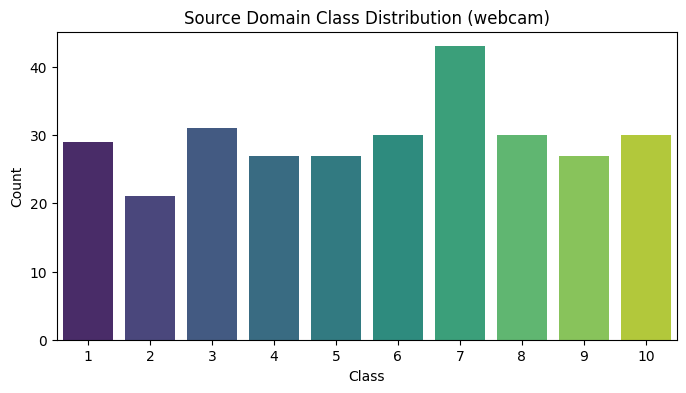

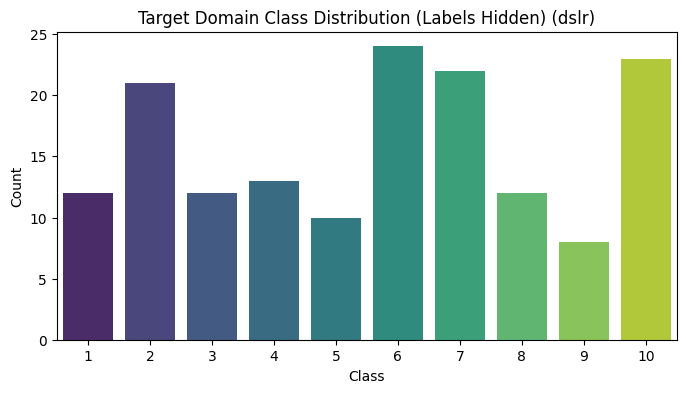

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 157 is different from 295)

In [8]:
if __name__ == "__main__":
    # Initialize Experiment Runner
    runner = ExperimentRunner(data_dir='../data/CaffeNet')

    # Define source and target domains
    source_domain = 'webcam'
    target_domain = 'dslr'

    # Run Subspace Alignment without outlier removal and class balancing
    runner.run_subspace_alignment(
        source_domain=source_domain,
        target_domain=target_domain,
        n_components=50,  # Adjusted number of components
        kernel='rbf',
        kernel_params={'gamma': 0.1},
        remove_outliers=False,
        balance_classes=False
    )

    # Run Subspace Alignment with outlier removal and class balancing
    runner.run_subspace_alignment(
        source_domain=source_domain,
        target_domain=target_domain,
        n_components=50,
        kernel='rbf',
        kernel_params={'gamma': 0.1},
        remove_outliers=True,
        balance_classes=True
    )

    # Run Sinkhorn OT without outlier removal and class balancing
    runner.run_sinkhorn_ot(
        source_domain=source_domain,
        target_domain=target_domain,
        reg_e=0.1,
        remove_outliers=False,
        balance_classes=False
    )

    # Run Sinkhorn OT with outlier removal and class balancing
    runner.run_sinkhorn_ot(
        source_domain=source_domain,
        target_domain=target_domain,
        reg_e=0.1,
        remove_outliers=True,
        balance_classes=True
    )
